## NeurIPS inner cross-validation hyperparameter analysis

**Purpose:** Grid search validation set experimental results for SMT hyperparameters

**Associated Figures:** Fig. 7

**Author:** Alexander Ratzan    
**Project:** Predicting Functional Brain Connectivity with Context-Aware Deep Neural Networks (NeurIPS 2025)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-21 17:52:33.153650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 17:52:34.090875: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 17:52:34.597718: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-21 17:52:34.598450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

Resorting genes by reference genome order


#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 3.3%
RAM Usage: 7.5%
Available RAM: 931.7G
Total RAM: 1007.0G
52.4G


## Wandb Query <a id="sims"></a>

In [5]:
api = wandb.Api()
project_path = "alexander-ratzan-new-york-university/gx2conn"

In [62]:
def fetch_and_summarize_wandb_runs_smt_innercv(model, cv_type, null_model, param_to_vary=None, param_values=None, sort_genes='refgenome', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=60, before_last=0):
    """
    Fetches wandb runs and summarizes validation metrics for hyperparameter search.
    
    Args:
        model (str): Model name
        cv_type (str): CV type ('random', 'spatial', 'schaefer', 'lobe')
        null_model (str): Null model label
        param_to_vary (str): Hyperparameter to evaluate (e.g. 'token_encoder_dim')
        param_values (list): Values to test for param_to_vary
        feature_type (str): Feature type
        target (str): Target connectome type
        within_last (int): Search for runs within this many days ago
        before_last (int): Exclude runs from this many days ago
    
    Returns:
        summary_df (pd.DataFrame): Mean and std of validation metrics per param value
    """
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Default parameters
    default_params = {
        "token_encoder_dim": 60,
        "encoder_output_dim": 10,
        "use_alibi": True,
        "aug_prob": 0.3,
        "aug_style": "curriculum_swap_linear_decay"
    }
    
    results = []
    
    # If no param specified, just use defaults
    if param_to_vary is None:
        param_values = [None]
    for param_val in param_values:
        # Set up filters with default params
        filters = {
            "tags": {
                "$all": [
                    "inner cross validation",
                    f"model_{model}",
                    f"target_{target}", 
                    f"cv_type_{cv_type}",
                    f"null_model_{null_model}",
                    f"feature_type_{feature_type}",
                    f"gene_list_{gene_list}",
                    f"sort_genes_{sort_genes}"
                ],
            },
            "created_at": {
                "$gte": start_time.isoformat(),
                "$lte": end_time.isoformat()
            },
            "state": "finished"
        }
        
        # Add all default params to filters
        for param, val in default_params.items():
            if param != param_to_vary:
                filters[f"config.{param}"] = val
                
        # Override with param being tested if specified
        if param_to_vary is not None:
            filters[f"config.{param_to_vary}"] = param_val

        print(filters)

        runs = api.runs(project_path, filters=filters, order="-created_at")
        print(f"🔍 Found {len(runs)} runs")
        val_losses = []
        val_pearsons = []
        
        for run in runs:
            val_losses.append(run.summary.get("mean_val_loss", np.nan))
            val_pearsons.append(run.summary.get("mean_val_pearson", np.nan))
        print(val_losses)
        print(val_pearsons)

        param_name = param_to_vary if param_to_vary else "default"
        results.append({
            param_name: param_val if param_to_vary else "default",
            "mean_val_loss": np.mean(val_losses),
            "std_val_loss": np.std(val_losses),
            "mean_val_pearson": np.mean(val_pearsons),
            "std_val_pearson": np.std(val_pearsons)
        })
        
    results = pd.DataFrame(results)
    display(results)
    return results

model = 'shared_transformer'
cv_type = 'random'
null_model = 'none'
before_last = 1
within_last = 5

# param_to_vary='token_encoder_dim'
# param_values=[20, 30, 60, 180]
# before_last = 2
# within_last = 5

# param_to_vary='encoder_output_dim'
# param_values=[1, 3, 5, 10]
# before_last = 2
# within_last = 5

# param_to_vary='use_alibi'
# param_values=[True, False]
# before_last = 3
# within_last = 5

# param_to_vary='aug_style'
# param_values=['linear_decay', 'linear_increase', 'linear_peak', 'constant', 'curriculum_swap_constant', 'curriculum_swap_linear_decay', 'curriculum_swap_linear_increase']
# before_last = 0
# within_last = 5

#  aram_to_vary='aug_prob'
# param_values=[0.0, 0.3, 0.45, 0.7]
# before_last = 0
# within_last = 5

In [17]:
param_to_vary='token_encoder_dim'
param_values=[20, 30, 60, 180]
before_last = 3
within_last = 5

token_encoder_df = fetch_and_summarize_wandb_runs_smt_innercv(model, cv_type, null_model, param_to_vary=param_to_vary, param_values=param_values, sort_genes='refgenome', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last)

{'tags': {'$all': ['inner cross validation', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'null_model_none', 'feature_type_transcriptome', 'gene_list_0.2', 'sort_genes_refgenome']}, 'created_at': {'$gte': '2025-10-16T17:58:13.751415', '$lte': '2025-10-18T17:58:13.751408'}, 'state': 'finished', 'config.encoder_output_dim': 10, 'config.use_alibi': False, 'config.aug_prob': 0.0, 'config.token_encoder_dim': 20}
🔍 Found 22 runs
[0.017087440722836897, 0.013956319827299852, 0.01620631507382943, 0.016910090541037228, 0.02021878742827819, 0.018737289481438123, 0.016013872523147326, 0.017104347952856466, 0.014943391156311218, 0.01617699531981578, 0.013889577884513598, 0.02022370008321909, 0.01703349708651121, 0.0178343215240882, 0.01902091968804598, 0.013743431092454838, 0.015996450415024392, 0.01630658183533412, 0.018710433003994133, 0.01500993171850076, 0.014298997819423676, 0.013697087872200288]
[0.7264573218061807, 0.7666873679139534, 0.740264355710792, 0.7202209363262789, 0.69

,token_encoder_dim,mean_val_loss,std_val_loss,mean_val_pearson,std_val_pearson
0,20,0.016505,0.001975,0.731703,0.027291
1,30,0.016713,0.002568,0.728259,0.036259
2,60,0.015842,0.001553,0.737883,0.029978
3,180,0.018121,0.002921,0.709808,0.047262


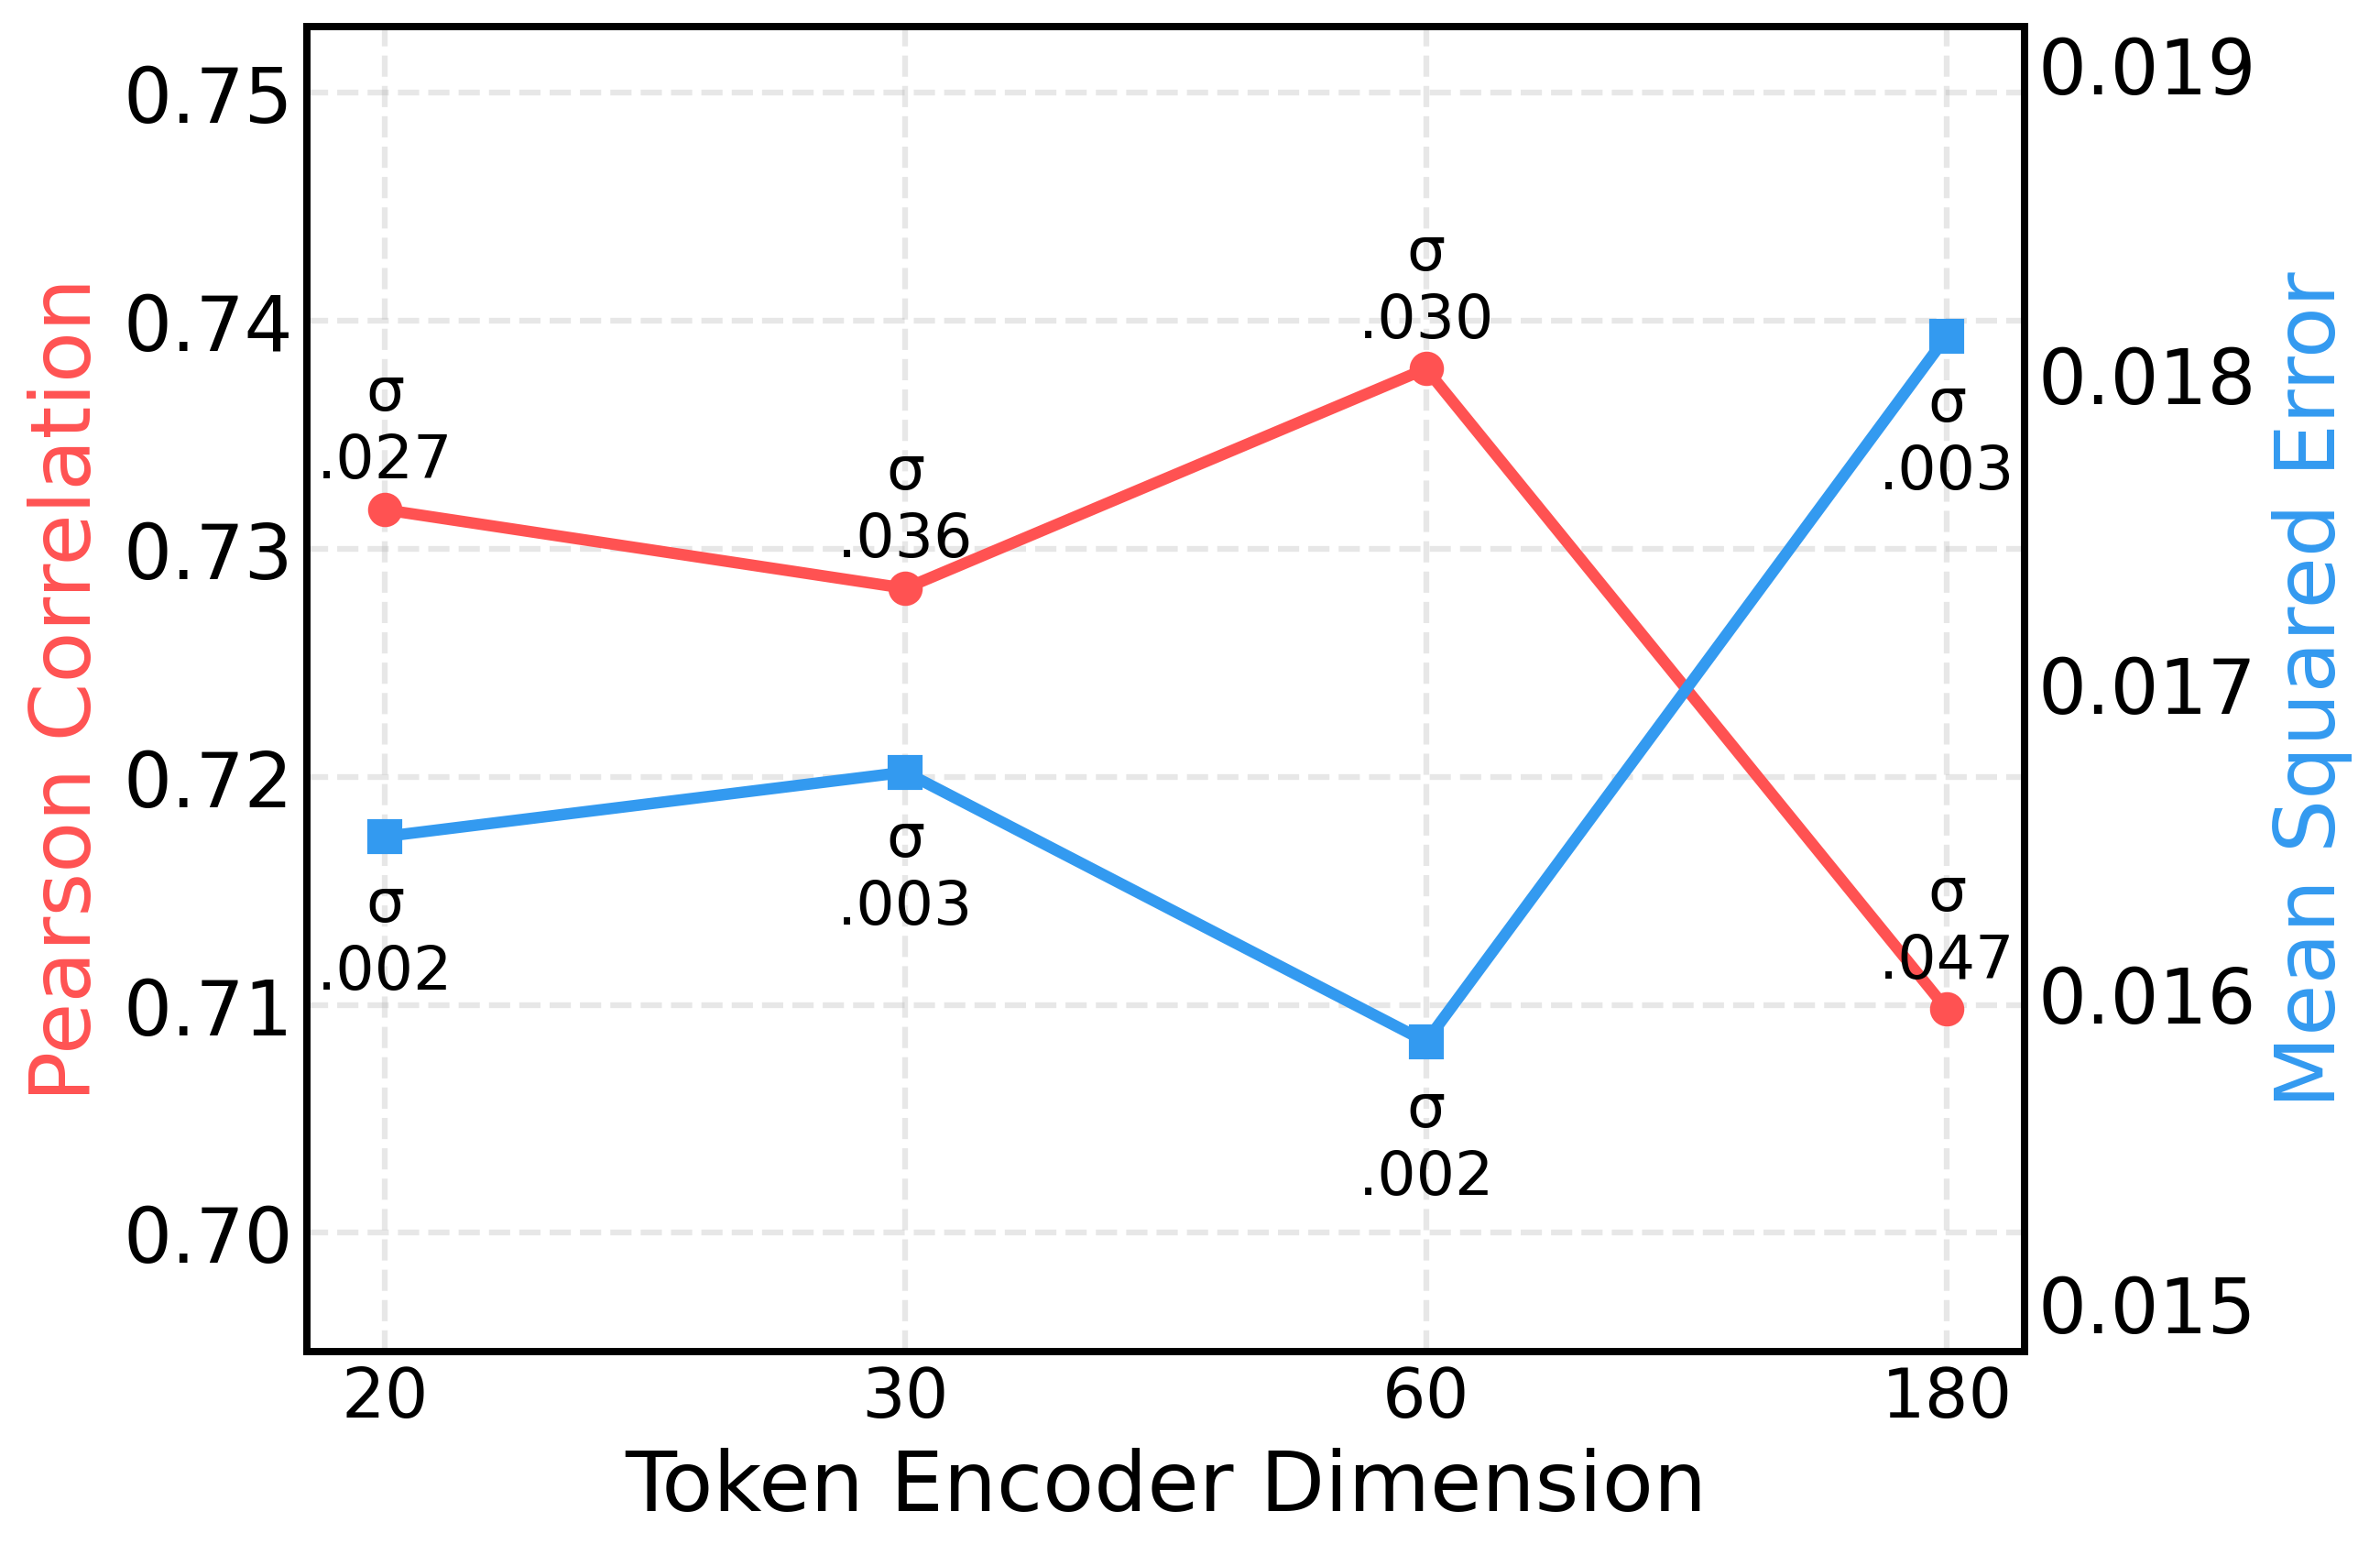

In [18]:
# Display the dataframe
token_encoder_df.head(50)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(token_encoder_df))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, token_encoder_df['mean_val_pearson'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(token_encoder_df['mean_val_pearson'], token_encoder_df['std_val_pearson'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = token_encoder_df['mean_val_pearson'].min() - 0.015
pearson_max = token_encoder_df['mean_val_pearson'].max() + 0.015
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE) #, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, token_encoder_df['mean_val_loss'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(token_encoder_df['mean_val_loss'], token_encoder_df['std_val_loss'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = token_encoder_df['mean_val_loss'].min() - 0.001
mse_max = token_encoder_df['mean_val_loss'].max() + 0.001
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE) #, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, token_encoder_df['token_encoder_dim'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Token Encoder Dimension', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
param_to_vary='encoder_output_dim'
param_values=[1, 3, 5, 10]
before_last = 3
within_last = 4

token_output_df = fetch_and_summarize_wandb_runs_smt_innercv(model, cv_type, null_model, param_to_vary=param_to_vary, param_values=param_values, sort_genes='refgenome', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last)

{'tags': {'$all': ['inner cross validation', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'null_model_none', 'feature_type_transcriptome', 'gene_list_0.2', 'sort_genes_refgenome']}, 'created_at': {'$gte': '2025-10-17T18:00:43.443881', '$lte': '2025-10-18T18:00:43.443874'}, 'state': 'finished', 'config.token_encoder_dim': 60, 'config.use_alibi': False, 'config.aug_prob': 0.0, 'config.encoder_output_dim': 1}
🔍 Found 12 runs
[0.016389590329848804, 0.015550727812716594, 0.017315276755163304, 0.015859962441027164, 0.017194480062104188, 0.018426935475033063, 0.016922474552232485, 0.016377823785520516, 0.015909678732546475, 0.018770394488596, 0.015491111490588922, 0.017493203927118044]
[0.7027013339445751, 0.727975989515924, 0.721704776685986, 0.6950496715155312, 0.7423990962101402, 0.6480579503939515, 0.7251706521067784, 0.7068766009294141, 0.7559652127710228, 0.7238786363609544, 0.7528705303990388, 0.703631064346753]
{'tags': {'$all': ['inner cross validation', 'model_shared_t

,encoder_output_dim,mean_val_loss,std_val_loss,mean_val_pearson,std_val_pearson
0,1,0.016808,0.001030,0.717190,0.028028
1,3,0.015908,0.001027,0.734989,0.032875
2,5,0.016136,0.001284,0.733861,0.015417
3,10,0.015842,0.001553,0.737883,0.029978


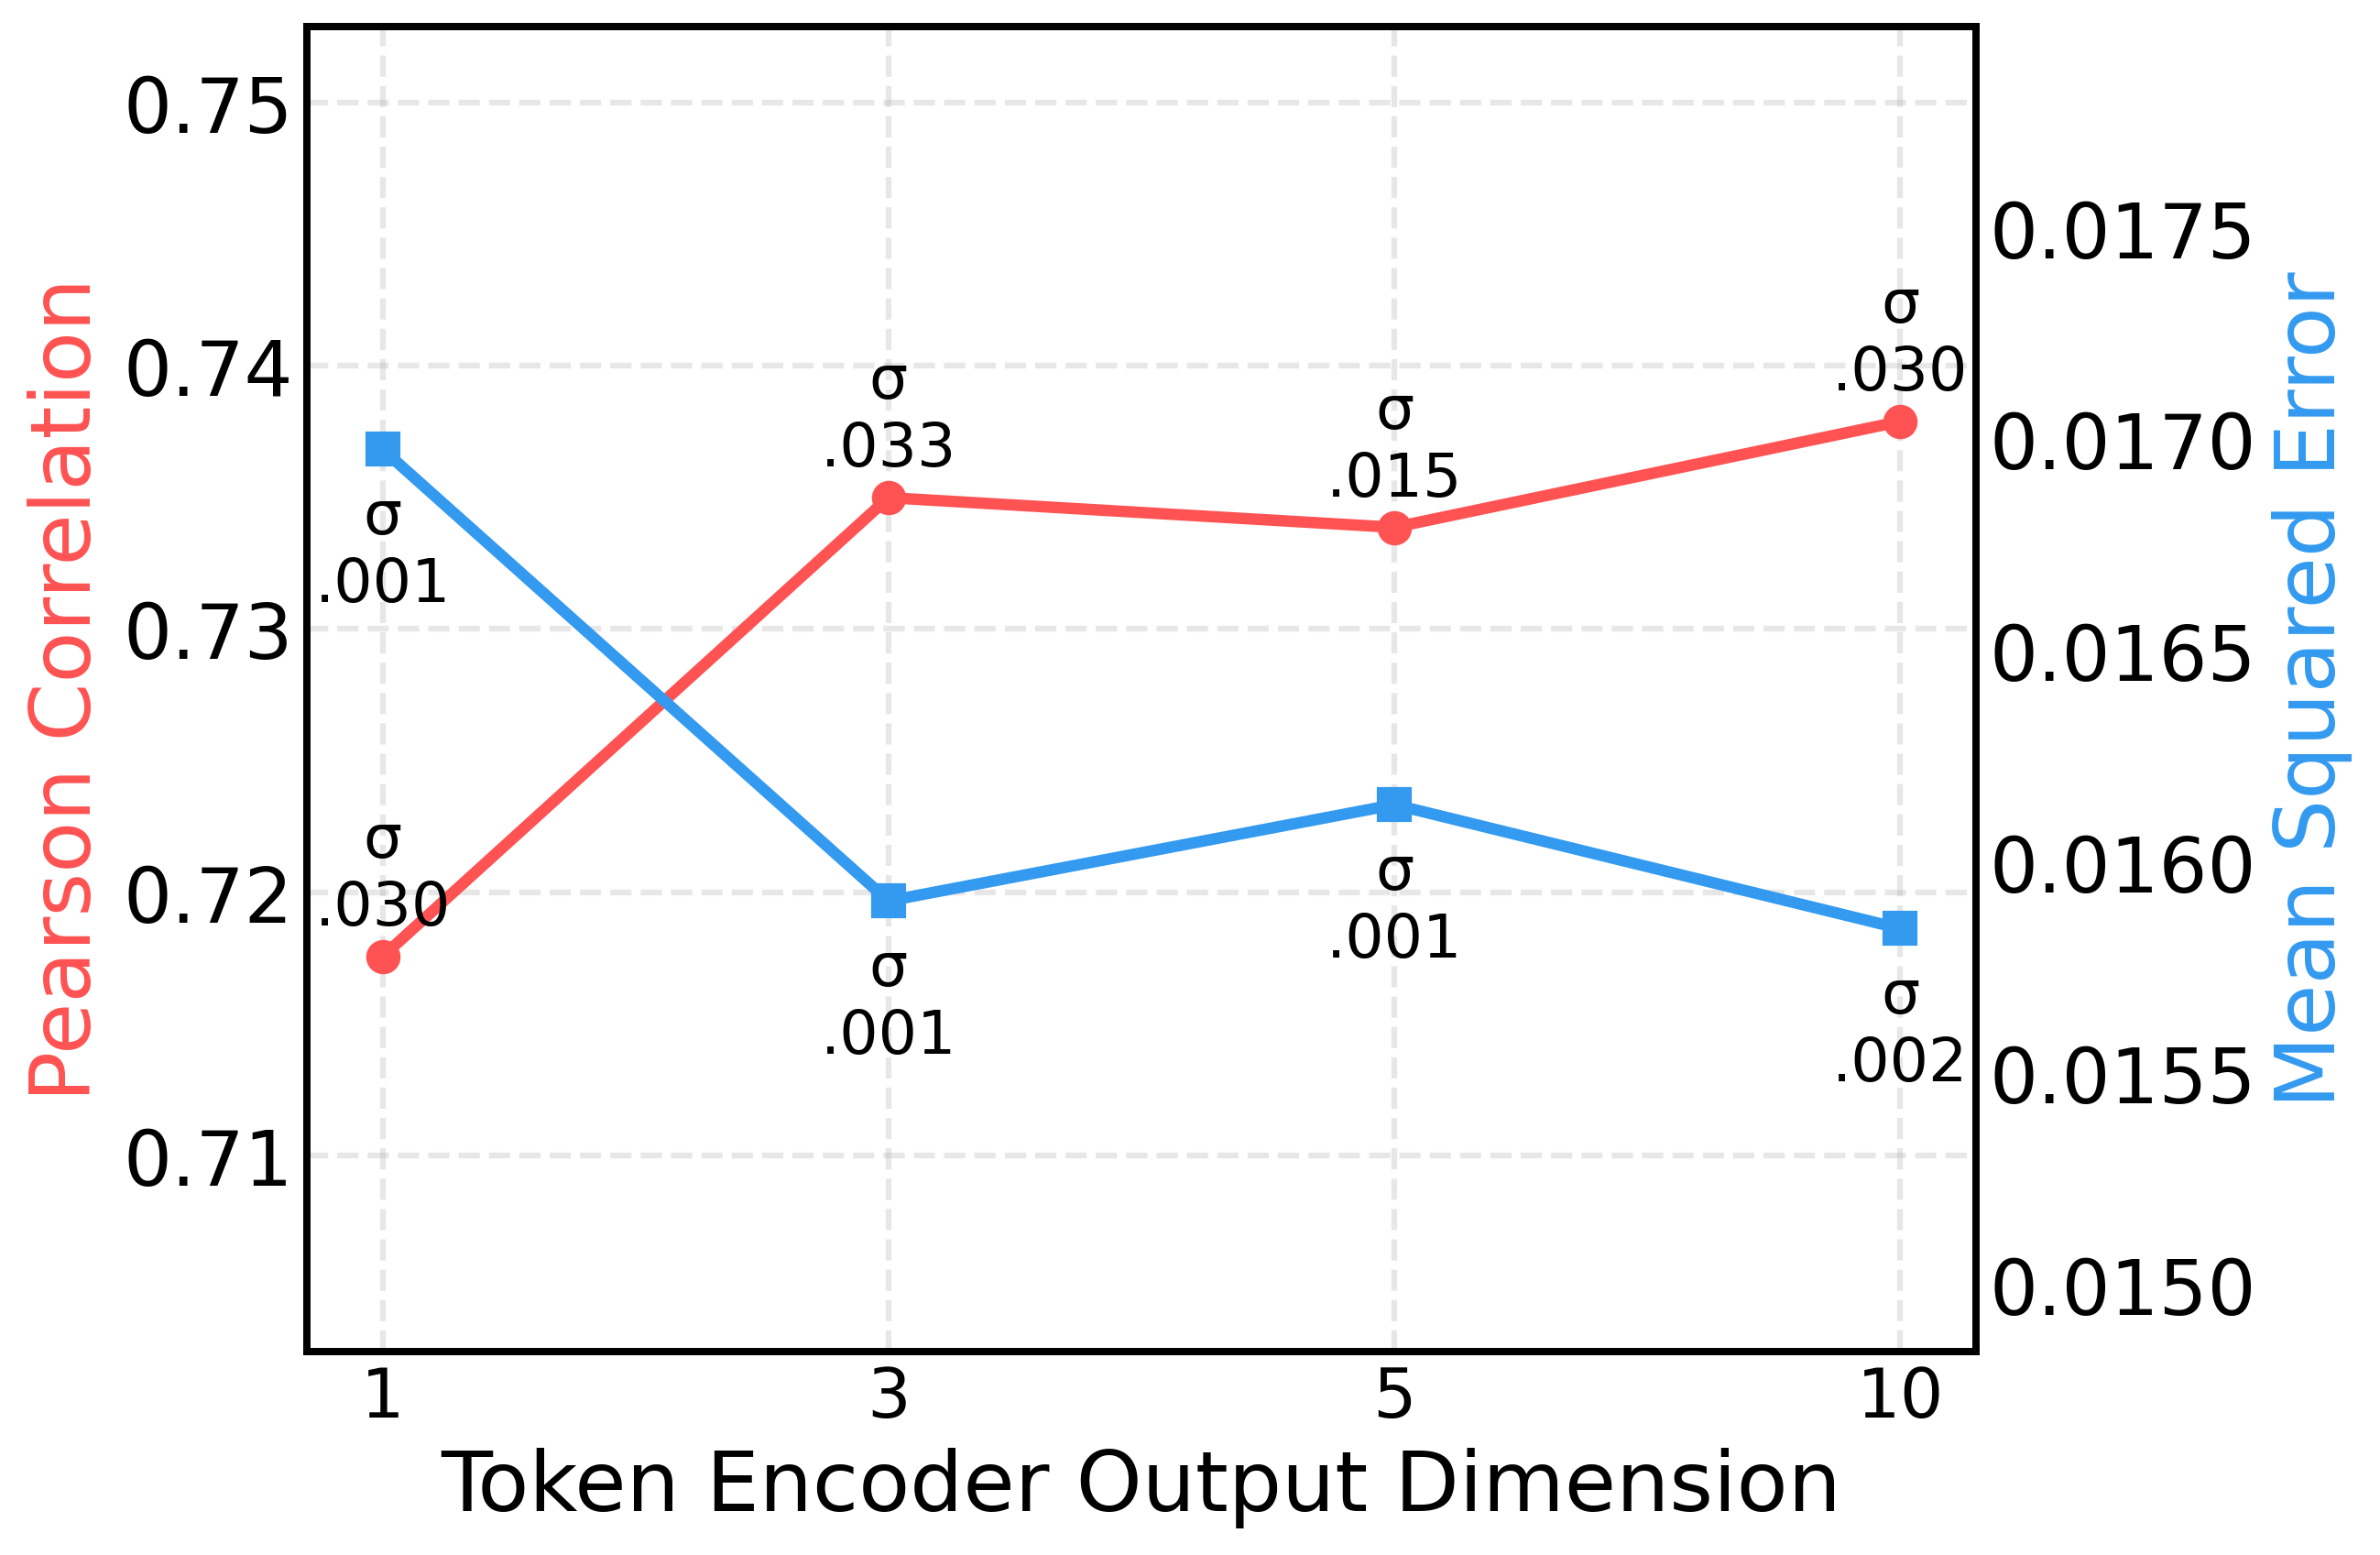

In [22]:
# Display the dataframe
token_output_df.head(50)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(token_output_df))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, token_output_df['mean_val_pearson'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(token_output_df['mean_val_pearson'], token_output_df['std_val_pearson'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = token_output_df['mean_val_pearson'].min() - 0.015
pearson_max = token_output_df['mean_val_pearson'].max() + 0.015
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE) #, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, token_output_df['mean_val_loss'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(token_output_df['mean_val_loss'], token_output_df['std_val_loss'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = token_output_df['mean_val_loss'].min() - 0.001
mse_max = token_output_df['mean_val_loss'].max() + 0.001
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE) #, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, token_output_df['encoder_output_dim'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Token Encoder Output Dimension', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
param_to_vary='use_alibi'
param_values=[True, False]
before_last = 2
within_last = 3

alibi_df = fetch_and_summarize_wandb_runs_smt_innercv(model, cv_type, null_model, param_to_vary=param_to_vary, param_values=param_values, sort_genes='refgenome', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last)

{'tags': {'$all': ['inner cross validation', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'null_model_none', 'feature_type_transcriptome', 'gene_list_0.2', 'sort_genes_refgenome']}, 'created_at': {'$gte': '2025-10-18T18:01:31.966898', '$lte': '2025-10-19T18:01:31.966891'}, 'state': 'finished', 'config.token_encoder_dim': 60, 'config.encoder_output_dim': 10, 'config.aug_prob': 0.0, 'config.use_alibi': True}
🔍 Found 40 runs
[0.01311421634342808, 0.017197938349384528, 0.017927240293759566, 0.018482961906836584, 0.016444724662086137, 0.017977633943351414, 0.015079807490110396, 0.016784232396345872, 0.015283889781970244, 0.015843883300056823, 0.013534447679725977, 0.0169163470228131, 0.014366488402279524, 0.017907492959728606, 0.01496995107915539, 0.01976669207215309, 0.018918116505329423, 0.01529991153914195, 0.018949177904197805, 0.017279427212018233, 0.012993843581240913, 0.015669077419890806, 0.018519058751945313, 0.021523497783793852, 0.01727248577830883, 0.01598930430526

,use_alibi,mean_val_loss,std_val_loss,mean_val_pearson,std_val_pearson
0,True,0.016262,0.001874,0.735173,0.032756
1,False,0.016633,0.002282,0.726421,0.033725


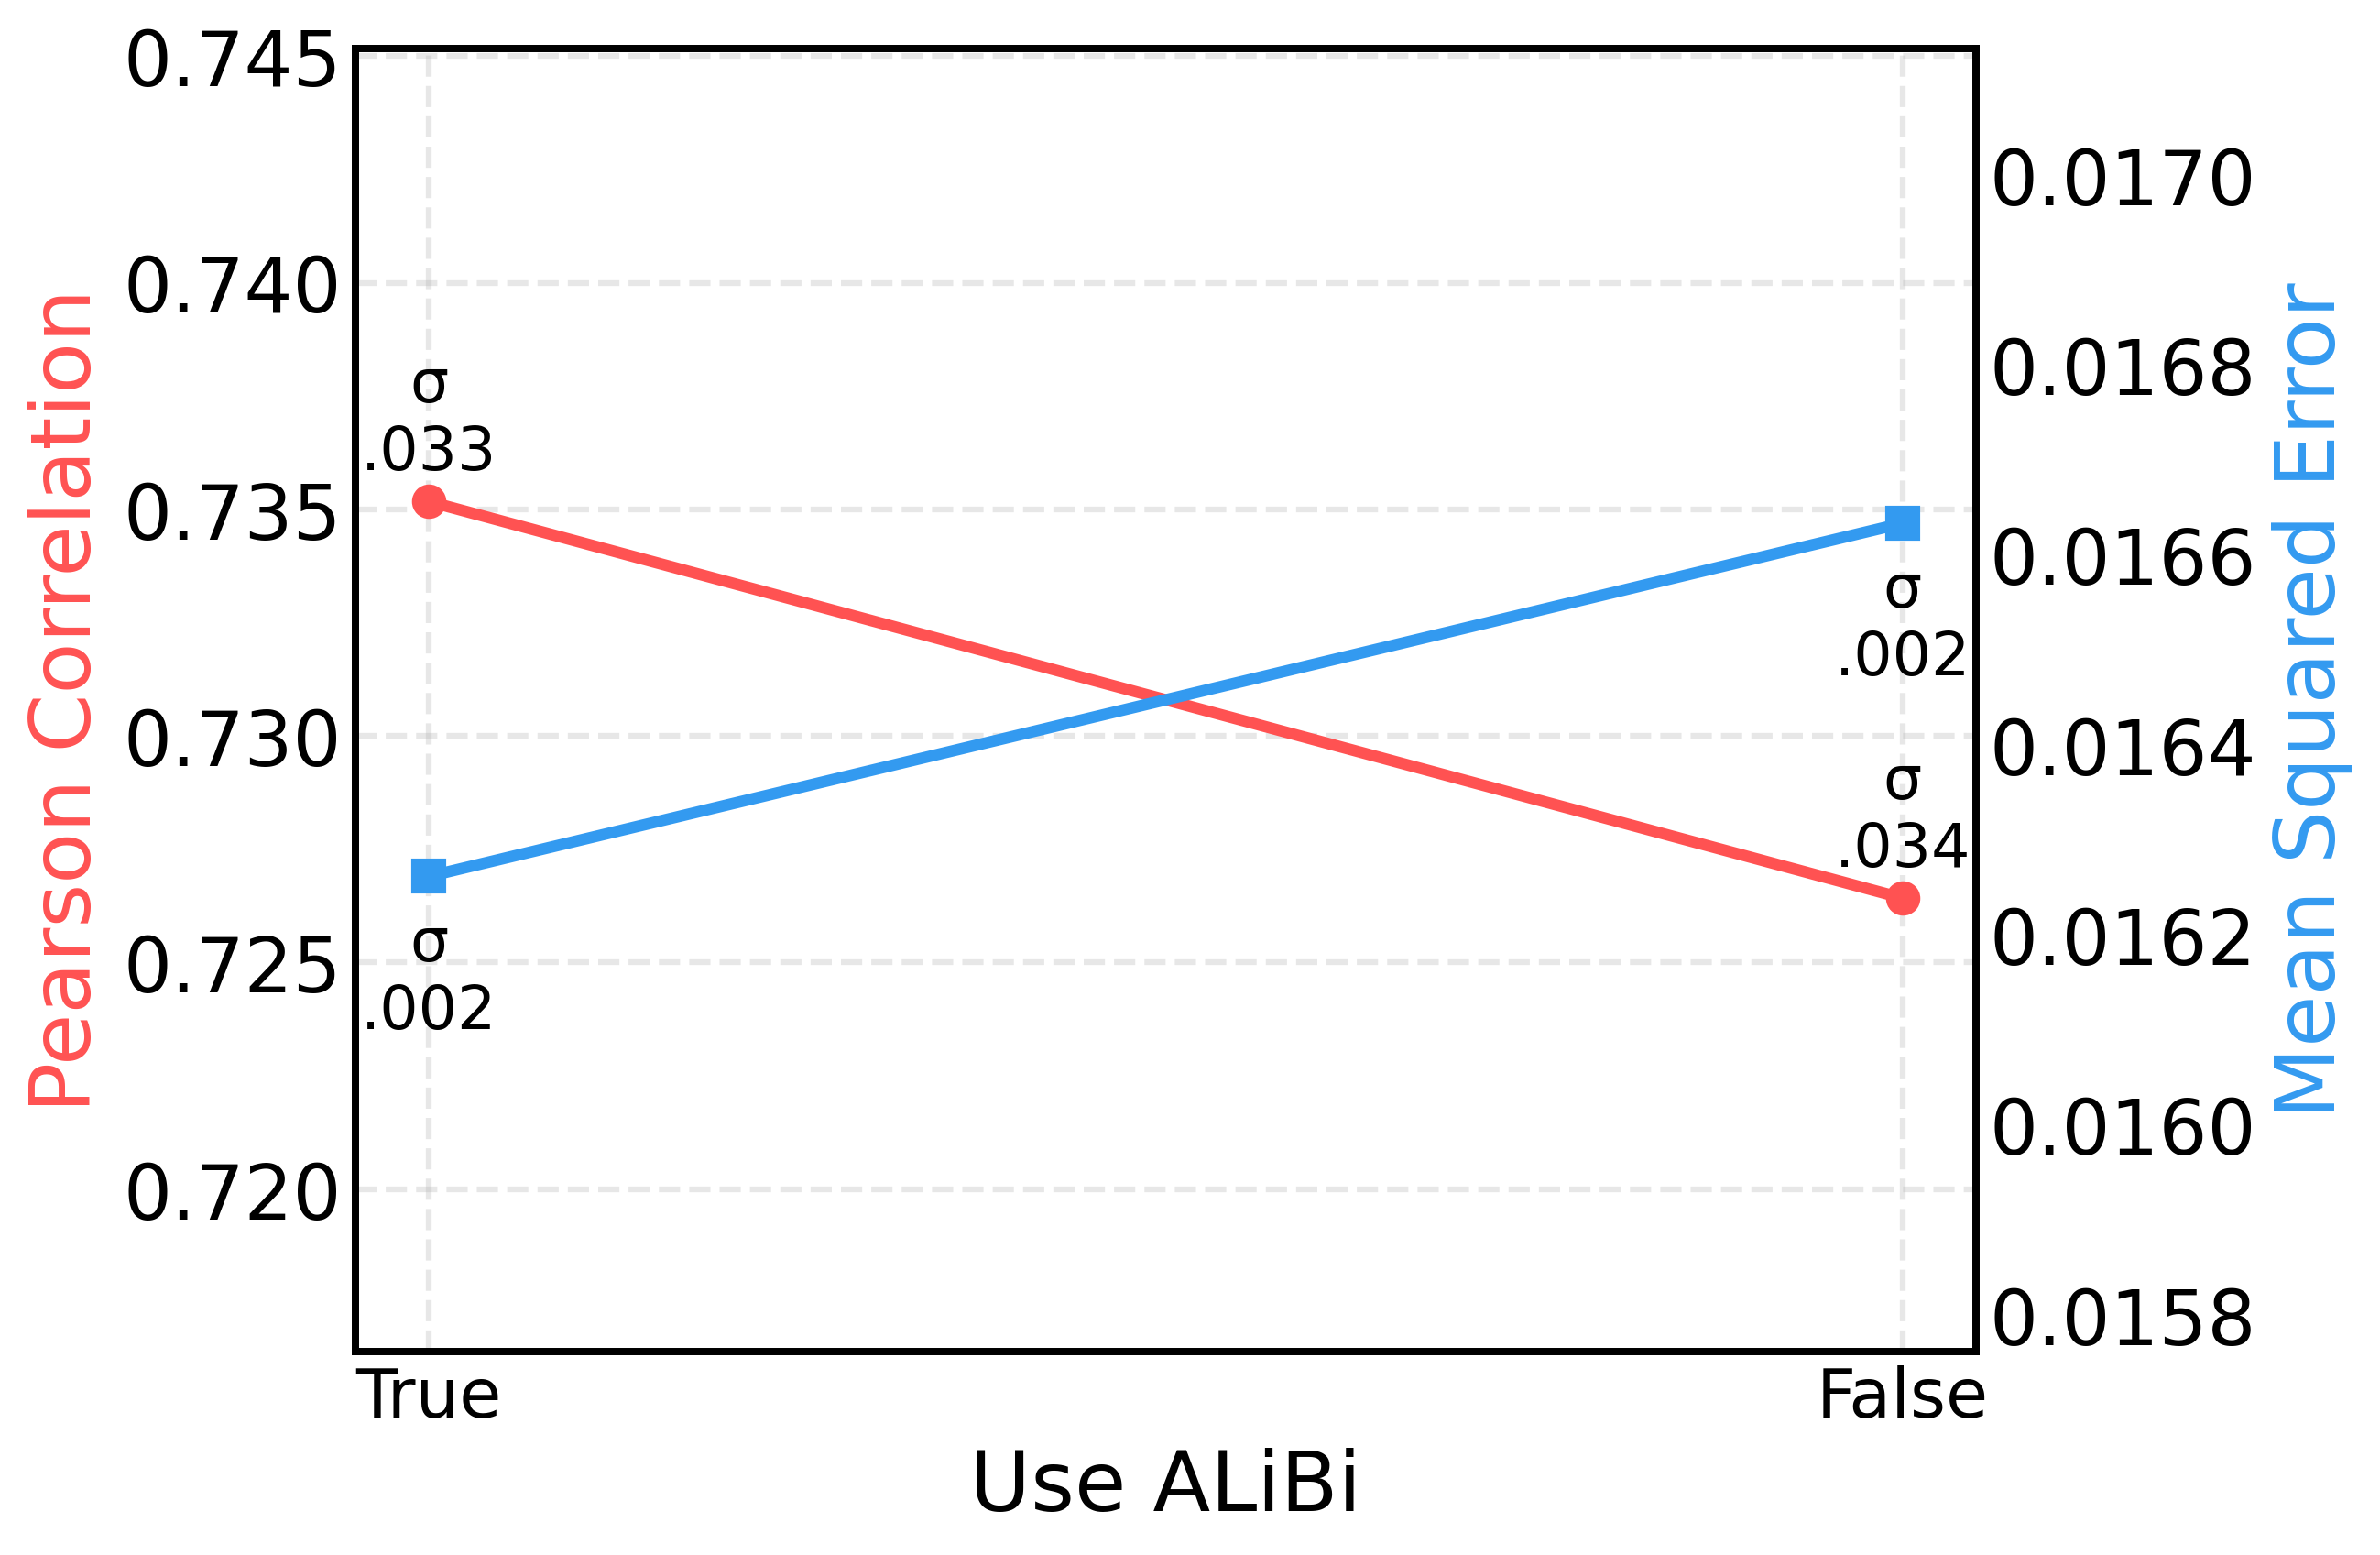

In [30]:
# Display the dataframe
alibi_df.head(50)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(alibi_df))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, alibi_df['mean_val_pearson'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(alibi_df['mean_val_pearson'], alibi_df['std_val_pearson'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = alibi_df['mean_val_pearson'].min() - 0.01
pearson_max = alibi_df['mean_val_pearson'].max() + 0.01
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE) #, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, alibi_df['mean_val_loss'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(alibi_df['mean_val_loss'], alibi_df['std_val_loss'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = alibi_df['mean_val_loss'].min() - 0.0005
mse_max = alibi_df['mean_val_loss'].max() + 0.0005
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE) #, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, alibi_df['use_alibi'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Use ALiBi', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [64]:
param_to_vary='aug_style'
param_values=['linear_decay', 'linear_increase', 'linear_peak', 'constant', 'curriculum_swap_constant', 'curriculum_swap_linear_decay']
before_last = 0
within_last = 3

aug_style_df = fetch_and_summarize_wandb_runs_smt_innercv(model, cv_type, null_model, param_to_vary=param_to_vary, param_values=param_values, sort_genes='refgenome', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last)

{'tags': {'$all': ['inner cross validation', 'model_shared_transformer', 'target_FC', 'cv_type_random', 'null_model_none', 'feature_type_transcriptome', 'gene_list_0.2', 'sort_genes_refgenome']}, 'created_at': {'$gte': '2025-10-18T18:22:17.098758', '$lte': '2025-10-21T18:22:17.098752'}, 'state': 'finished', 'config.token_encoder_dim': 60, 'config.encoder_output_dim': 10, 'config.use_alibi': True, 'config.aug_prob': 0.3, 'config.aug_style': 'linear_decay'}
🔍 Found 24 runs
[0.019525022550414387, 0.0172456748640308, 0.014735895925416395, 0.016043906852316398, 0.015080270805181218, 0.013856415171176195, 0.01595151680521667, 0.019546735422829024, 0.015581617364659904, 0.018111124849663332, 0.017178349823762592, 0.012497736409736369, 0.016584856453566596, 0.015711779616629847, 0.013967056687061604, 0.014275247822157463, 0.015921823375930007, 0.013330630931215216, 0.01469060330866621, 0.016029075952246785, 0.01704099736749553, 0.013430501173178736, 0.01534977755867518, 0.014305132978524152]
[

,aug_style,mean_val_loss,std_val_loss,mean_val_pearson,std_val_pearson
0,linear_decay,0.015666,0.001786,0.743702,0.035350
1,linear_increase,0.015591,0.001794,0.743043,0.030574
2,linear_peak,0.015335,0.001741,0.748971,0.028864
3,constant,0.015532,0.002139,0.745850,0.036715
4,curriculum_swap_constant,0.016155,0.002242,0.740697,0.033058
5,curriculum_swap_linear_decay,0.015486,0.001807,0.744905,0.031615


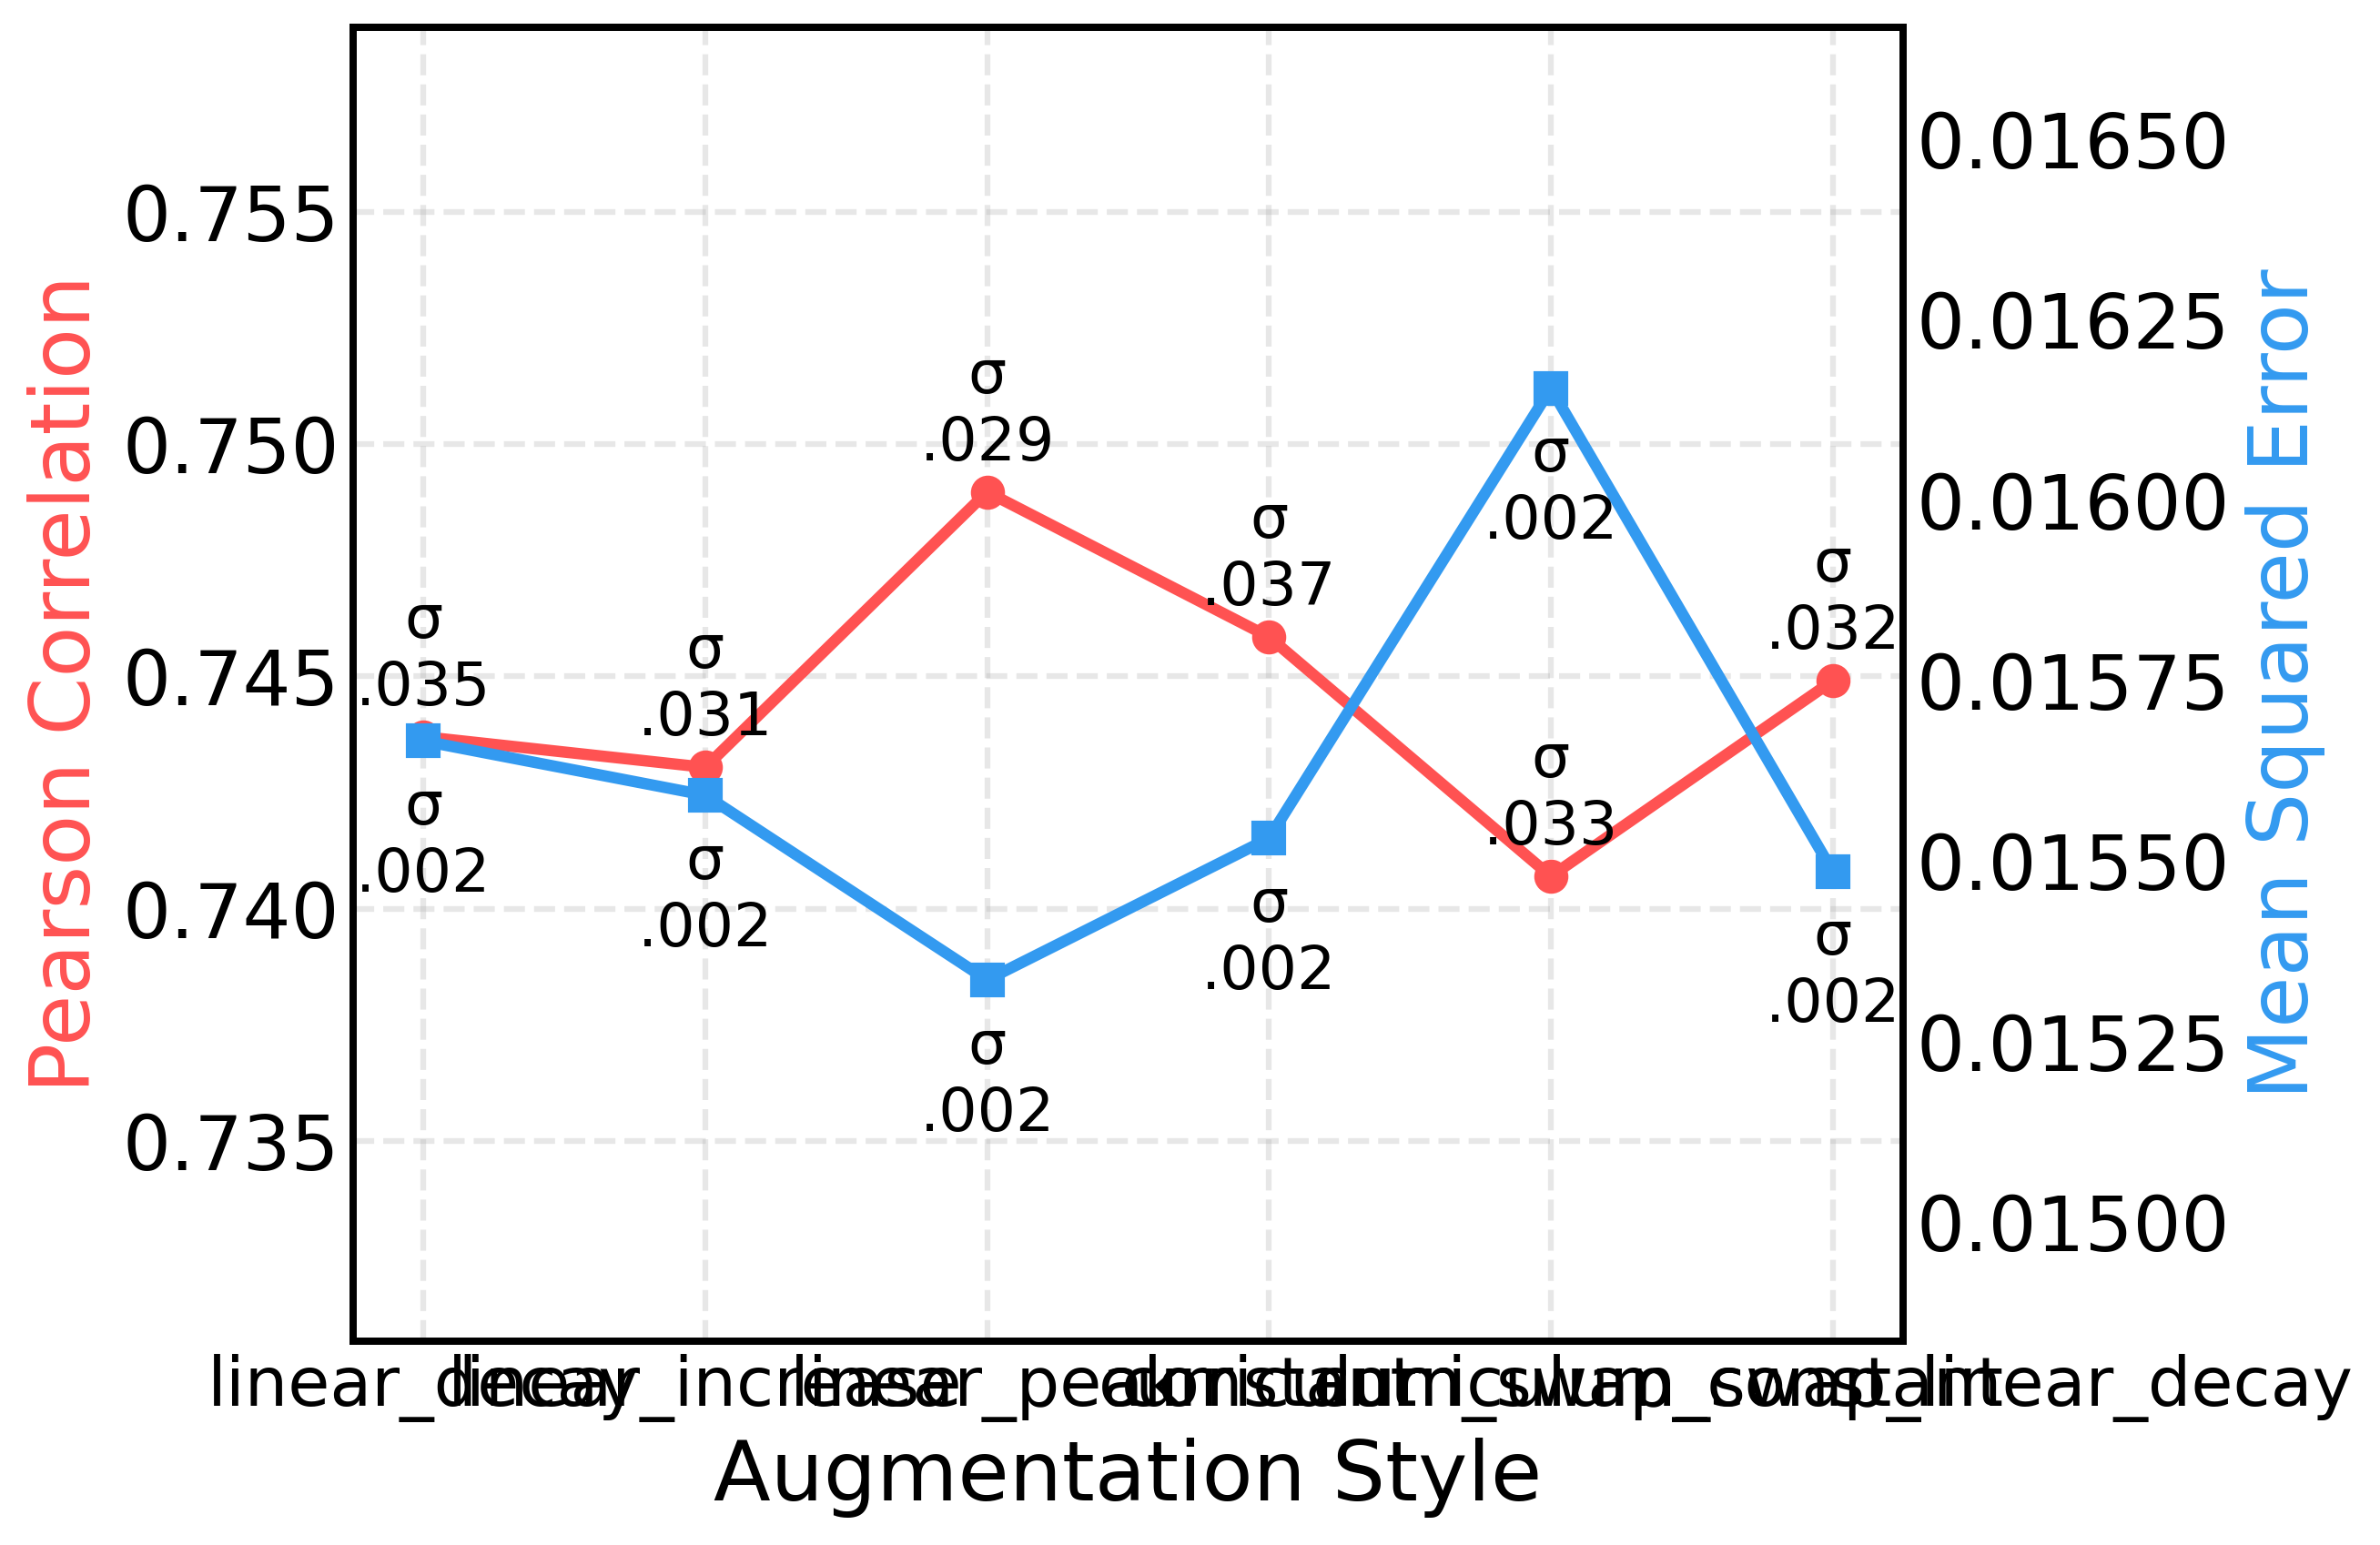

In [65]:
# Display the dataframe
aug_style_df.head(50)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(aug_style_df))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, aug_style_df['mean_val_pearson'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(aug_style_df['mean_val_pearson'], aug_style_df['std_val_pearson'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = aug_style_df['mean_val_pearson'].min() - 0.01
pearson_max = aug_style_df['mean_val_pearson'].max() + 0.01
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE) #, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, aug_style_df['mean_val_loss'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(aug_style_df['mean_val_loss'], aug_style_df['std_val_loss'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = aug_style_df['mean_val_loss'].min() - 0.0005
mse_max = aug_style_df['mean_val_loss'].max() + 0.0005
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE) #, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, aug_style_df['aug_style'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Augmentation Style', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


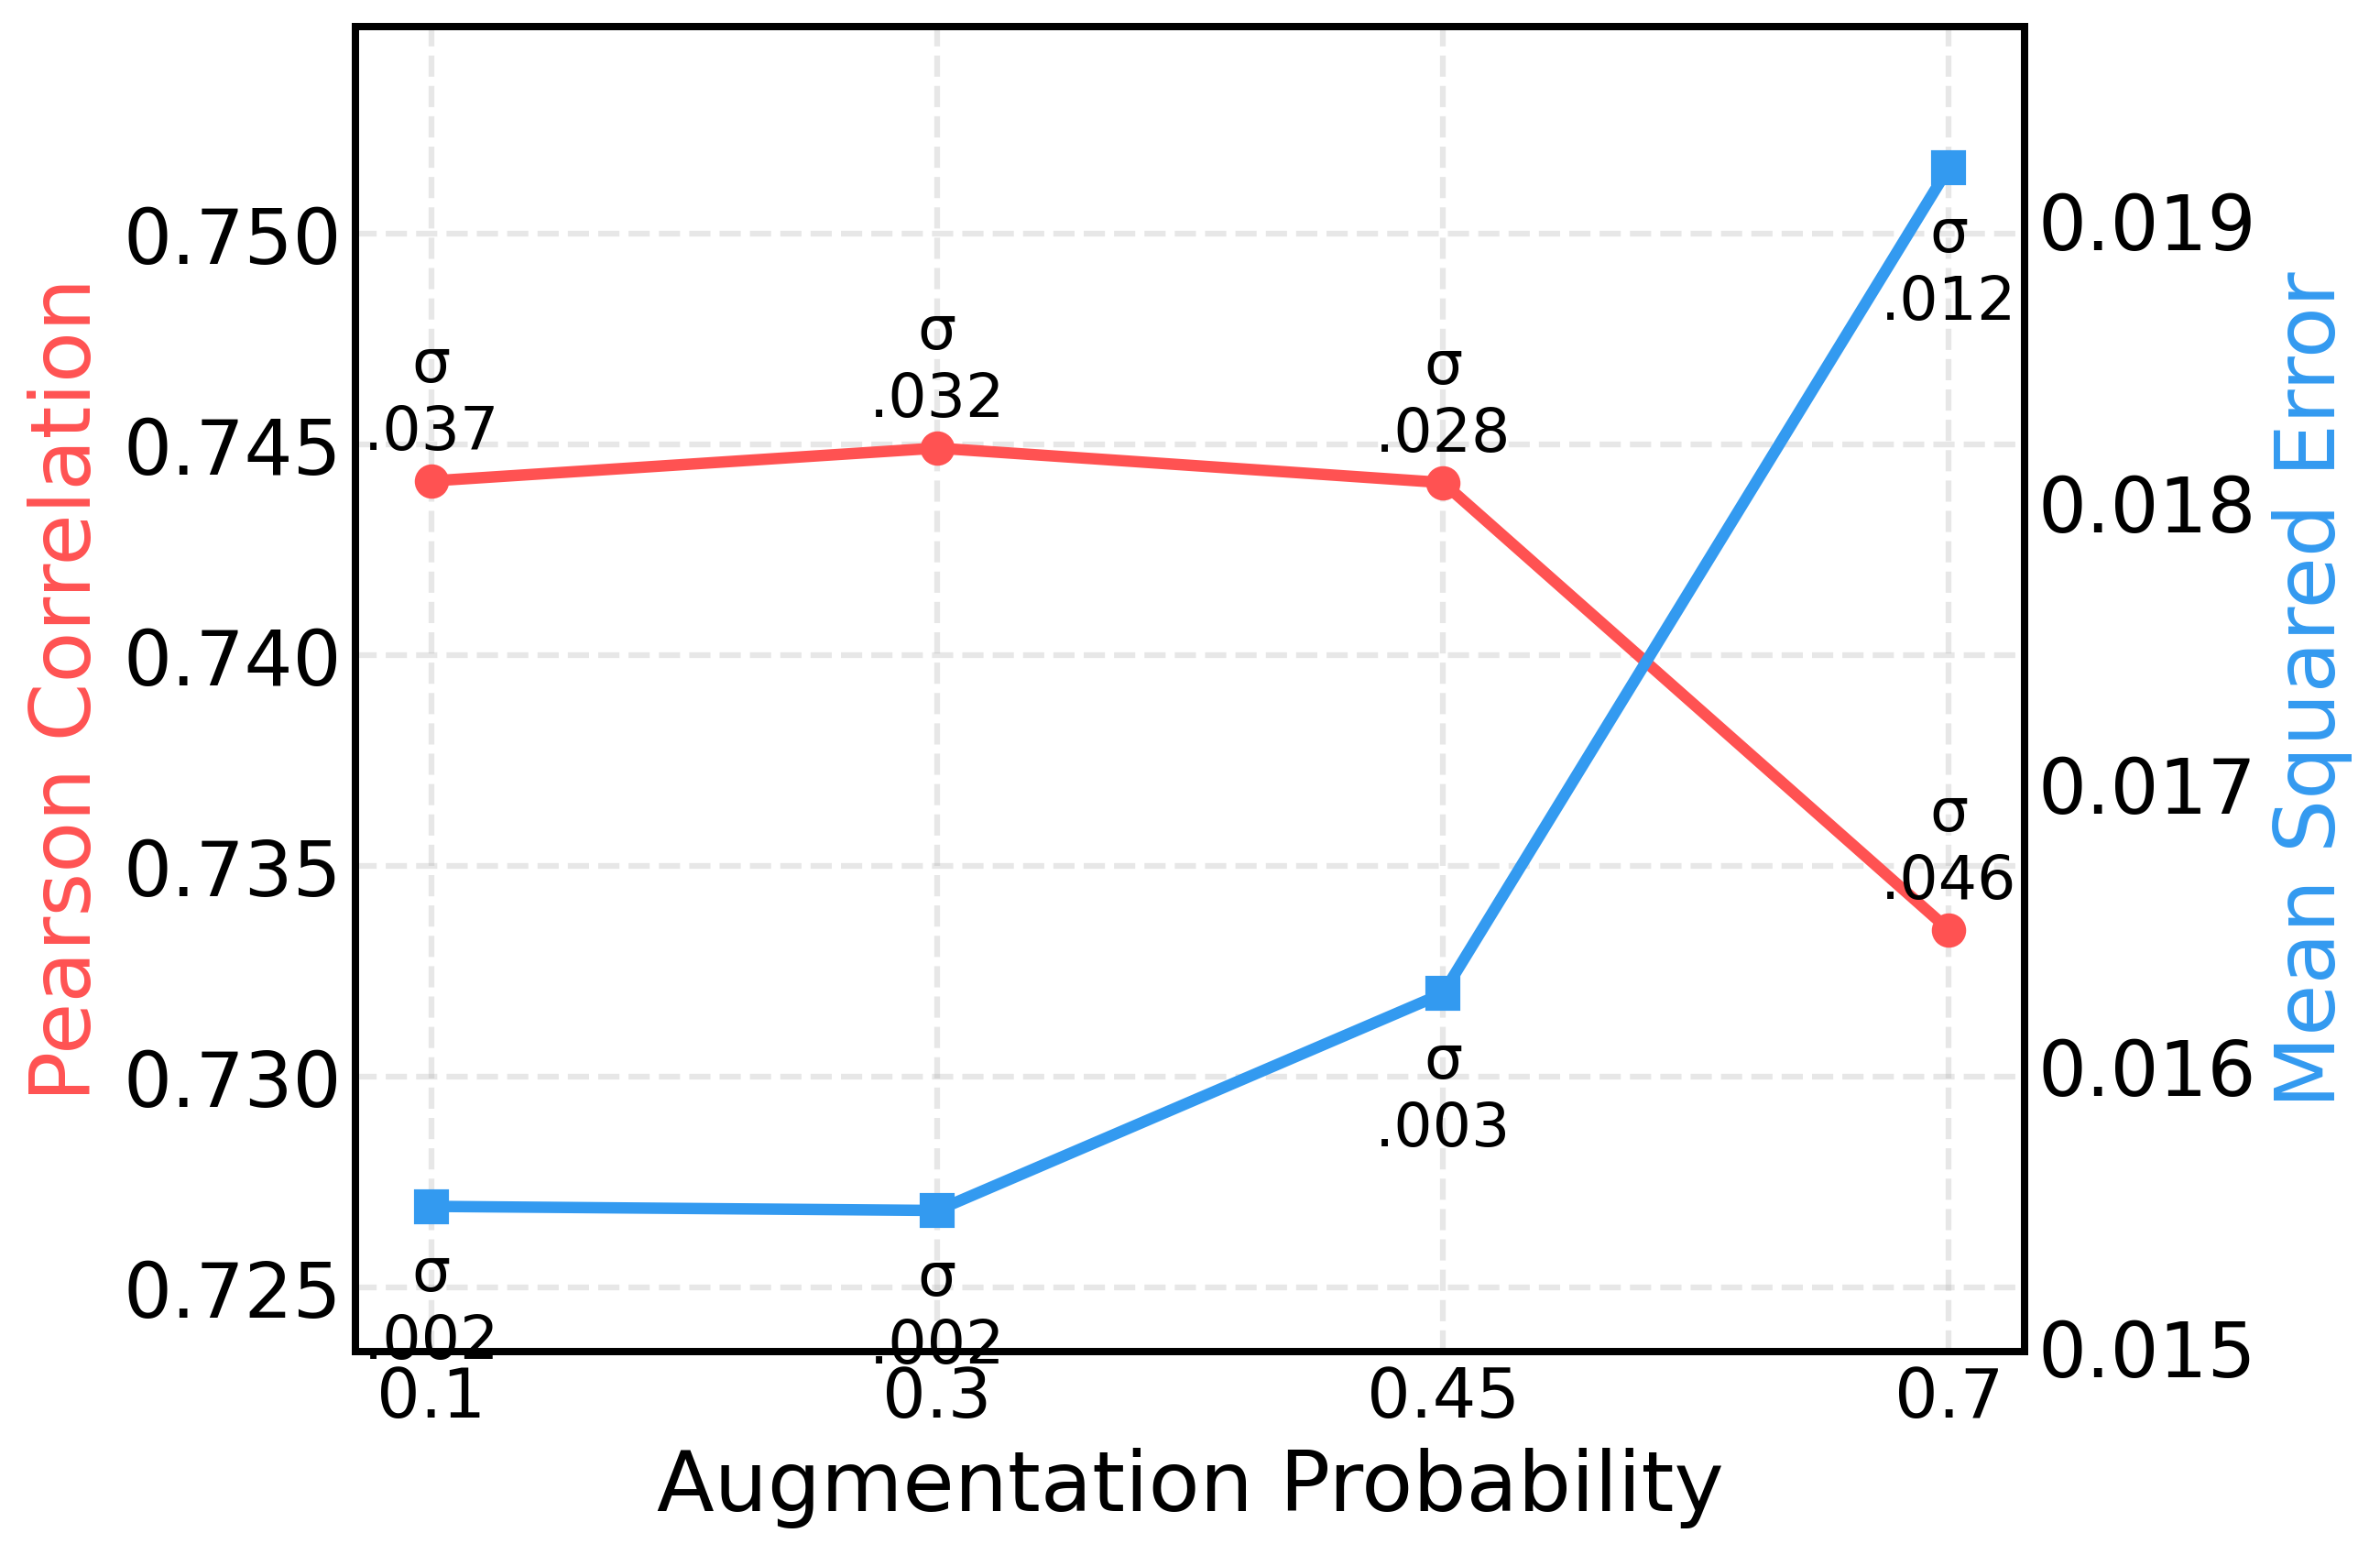

In [59]:
# Display the dataframe
aug_prob_df.head(50)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
ax2 = ax1.twinx()
FONT_SIZE=22

x = range(len(aug_prob_df))
soft_red = '#ff5252'
soft_blue = '#339af0'

# Plot Pearson correlation on left y-axis
line1 = ax1.plot(x, aug_prob_df['mean_val_pearson'], color=soft_red, linewidth=3, marker='o', markersize=8, label='Pearson-r')
# Add std annotations above points for Pearson
for i, (score, std) in enumerate(zip(aug_prob_df['mean_val_pearson'], aug_prob_df['std_val_pearson'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax1.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
pearson_min = aug_prob_df['mean_val_pearson'].min() - 0.01
pearson_max = aug_prob_df['mean_val_pearson'].max() + 0.01
ax1.set_ylim([pearson_min, pearson_max])
ax1.set_ylabel('Pearson Correlation', color=soft_red, fontsize=FONT_SIZE) #, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax1.tick_params(axis='both', length=0)

# Plot MSE on right y-axis
line2 = ax2.plot(x, aug_prob_df['mean_val_loss'], color=soft_blue, linewidth=3, marker='s', markersize=8, label='MSE')
# Add std annotations below points for MSE
for i, (score, std) in enumerate(zip(aug_prob_df['mean_val_loss'], aug_prob_df['std_val_loss'])):
    std_str = f"{std:.3f}".replace('0.', '.')
    ax2.annotate(f'σ\n{std_str}', 
                 xy=(i, score), xytext=(0, -10),
                 textcoords='offset points', ha='center', va='top',
                 fontsize=FONT_SIZE-6)

# Set y-axis limits dynamically
mse_min = aug_prob_df['mean_val_loss'].min() - 0.0005
mse_max = aug_prob_df['mean_val_loss'].max() + 0.0005
ax2.set_ylim([mse_min, mse_max])
ax2.set_ylabel('Mean Squared Error', color=soft_blue, fontsize=FONT_SIZE) #, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black', labelsize=FONT_SIZE-2)
ax2.tick_params(axis='both', length=0)

# X-axis formatting
plt.xticks(x, aug_prob_df['aug_prob'], rotation=45, ha='right')
ax1.tick_params(axis='x', labelsize=FONT_SIZE-4)
ax1.set_xlabel('Augmentation Probability', fontsize=FONT_SIZE)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
